In [1]:
from skimage import metrics
import torch
import numpy as np
import os
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from generative_ai.src.dataloader import DendritePFMDataset

## Calculation of RMSE and $\mu_{SIM}$ for VAE

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

test_dataset = DendritePFMDataset((3, 128, 128), os.path.join("data", "dataset_split.json"), split="test")
test_dataloader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)

vae = torch.load(os.path.join("ckpt", "CVAE.ckpt")).to(device)

rmses = []
ssims = []
ys = []
dids = []
# evaluate
with torch.no_grad():
    for iteration, (x, y, did) in enumerate(test_dataloader):

        ys.append(y[0])
        dids.append(did[0])

        # image and control variables
        recon_x = vae.inference(y)

        rmses.append(metrics.normalized_root_mse(x.cpu().numpy()[0].transpose(1, 2, 0), recon_x.cpu().numpy()[0].transpose(1, 2, 0)))
        ssims.append(metrics.structural_similarity(x.cpu().numpy()[0].transpose(1, 2, 0), recon_x.cpu().numpy()[0].transpose(1, 2, 0), win_size=3, data_range=(x.max()-x.min()).item()))


C:\Users\u0178651a\AppData\Local\Temp\ipykernel_49392\865497903.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae = torch.load(os.path.join("ckpt", "CVAE.ckpt")).to(de

C:\Users\u0178651a\AppData\Local\Temp\ipykernel_49392\1198879227.py:99: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


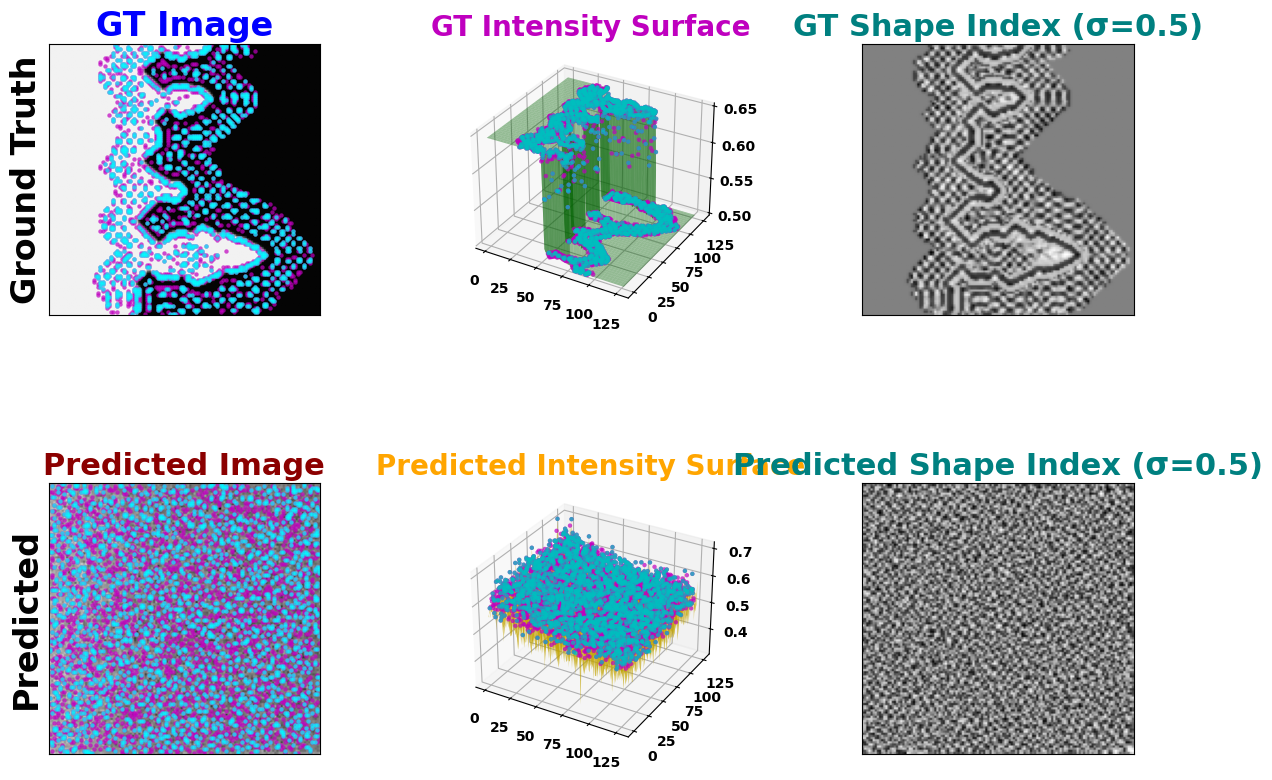

✅ 形状指数图已保存到: results\shape_index_compare.png


In [19]:
##########################################################
# 📊 可视化：Shape Index 对比 Ground Truth 与 预测图
##########################################################
import matplotlib.patheffects as path_effects
from scipy import ndimage as ndi

# 转换为 NumPy 格式（单通道）
gt_img = x.detach().cpu().numpy()[0, 0, :, :]
pd_img = recon_x.detach().cpu().numpy()[0, 0, :, :]

# ========== shape index 计算函数 ==========
def shape_index(img):
    gy, gx = np.gradient(img)
    gyy, gyx = np.gradient(gy)
    gxy, gxx = np.gradient(gx)
    H = (gxx + gyy) / 2.0
    K = gxx * gyy - gxy * gyx
    return np.arctan2(H, np.sqrt(np.abs(H**2 - K))) / np.pi + 0.5  # normalize 0-1

# ========== 计算 shape index ==========
s_gt = shape_index(gt_img)
s_pd = shape_index(pd_img)

# 平滑参数
sigma = 0.5
s_gt_smooth = ndi.gaussian_filter(s_gt, sigma=sigma)
s_pd_smooth = ndi.gaussian_filter(s_pd, sigma=sigma)

# 特征点选取
target = 0.0
delta = 0.3
py_gt, px_gt = np.where(np.abs(s_gt - target) < delta)
pz_gt = gt_img[py_gt, px_gt]

py_gt_s, px_gt_s = np.where(np.abs(s_gt_smooth - target) < delta)
pz_gt_s = gt_img[py_gt_s, px_gt_s]

py_pd, px_pd = np.where(np.abs(s_pd - target) < delta)
pz_pd = pd_img[py_pd, px_pd]

py_pd_s, px_pd_s = np.where(np.abs(s_pd_smooth - target) < delta)
pz_pd_s = pd_img[py_pd_s, px_pd_s]

# ========== 开始绘图 ==========
fig = plt.figure(figsize=(14, 9.5))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
scatter_settings = dict(alpha=0.7, s=10, linewidths=0)

# (1) Ground Truth 图像 + shape index 点
ax1 = fig.add_subplot(2, 3, 1)
ax1.imshow(gt_img, cmap="gray")
ax1.set_title("GT Image", color="blue", fontsize=24, weight="bold")
ax1.scatter(px_gt, py_gt, color='m', **scatter_settings)
ax1.scatter(px_gt_s, py_gt_s, color='cyan', **scatter_settings)
ax1.set_ylabel("Ground Truth", fontsize=24, weight="bold")

# (2) GT 三维曲面
ax2 = fig.add_subplot(2, 3, 2, projection='3d')
xgrid, ygrid = np.meshgrid(np.arange(gt_img.shape[1]), np.arange(gt_img.shape[0]))
ax2.plot_surface(xgrid, ygrid, gt_img, alpha=0.4, color='green')
ax2.scatter(px_gt, py_gt, pz_gt, color='m', **scatter_settings)
ax2.scatter(px_gt_s, py_gt_s, pz_gt_s, color='c', **scatter_settings)
ax2.set_title("GT Intensity Surface", fontsize=20, color='m', weight='bold')
ax2.set_zlim(np.min(gt_img), np.max(gt_img))

# (3) GT Shape Index 平滑后
ax3 = fig.add_subplot(2, 3, 3)
ax3.imshow(s_gt_smooth, cmap="gray")
ax3.set_title(f"GT Shape Index (σ={sigma})", color='teal', fontsize=22, weight='bold')

# (4) Predicted 图像 + shape index 点
ax4 = fig.add_subplot(2, 3, 4)
ax4.imshow(pd_img, cmap="gray")
ax4.set_ylabel("Predicted", fontsize=24, weight="bold")
ax4.scatter(px_pd, py_pd, color='m', **scatter_settings)
ax4.scatter(px_pd_s, py_pd_s, color='cyan', **scatter_settings)
ax4.set_title("Predicted Image", color='darkred', fontsize=22, weight='bold')

# (5) Predicted 三维曲面
ax5 = fig.add_subplot(2, 3, 5, projection='3d')
xgrid, ygrid = np.meshgrid(np.arange(pd_img.shape[1]), np.arange(pd_img.shape[0]))
ax5.plot_surface(xgrid, ygrid, pd_img, alpha=0.4, color='gold')
ax5.scatter(px_pd, py_pd, pz_pd, color='m', **scatter_settings)
ax5.scatter(px_pd_s, py_pd_s, pz_pd_s, color='c', **scatter_settings)
ax5.set_title("Predicted Intensity Surface", fontsize=20, color='orange', weight='bold')
ax5.set_zlim(np.min(pd_img), np.max(pd_img))

# (6) Predicted Shape Index 平滑后
ax6 = fig.add_subplot(2, 3, 6)
ax6.imshow(s_pd_smooth, cmap="gray")
ax6.set_title(f"Predicted Shape Index (σ={sigma})", color='teal', fontsize=22, weight='bold')

# 全局样式
for ax in [ax1, ax3, ax4, ax6]:
    ax.tick_params(axis='both', labelsize=10, bottom=False, left=False, labelbottom=False, labelleft=False)
for ax in [ax2, ax5]:
    for label in ax.get_xticklabels() + ax.get_yticklabels() + ax.get_zticklabels():
        label.set_fontweight('bold')
plt.tight_layout()

save_path = os.path.join("results", "shape_index_compare.png")
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path, transparent=True, dpi=300)
plt.show()

print(f"✅ 形状指数图已保存到: {save_path}")

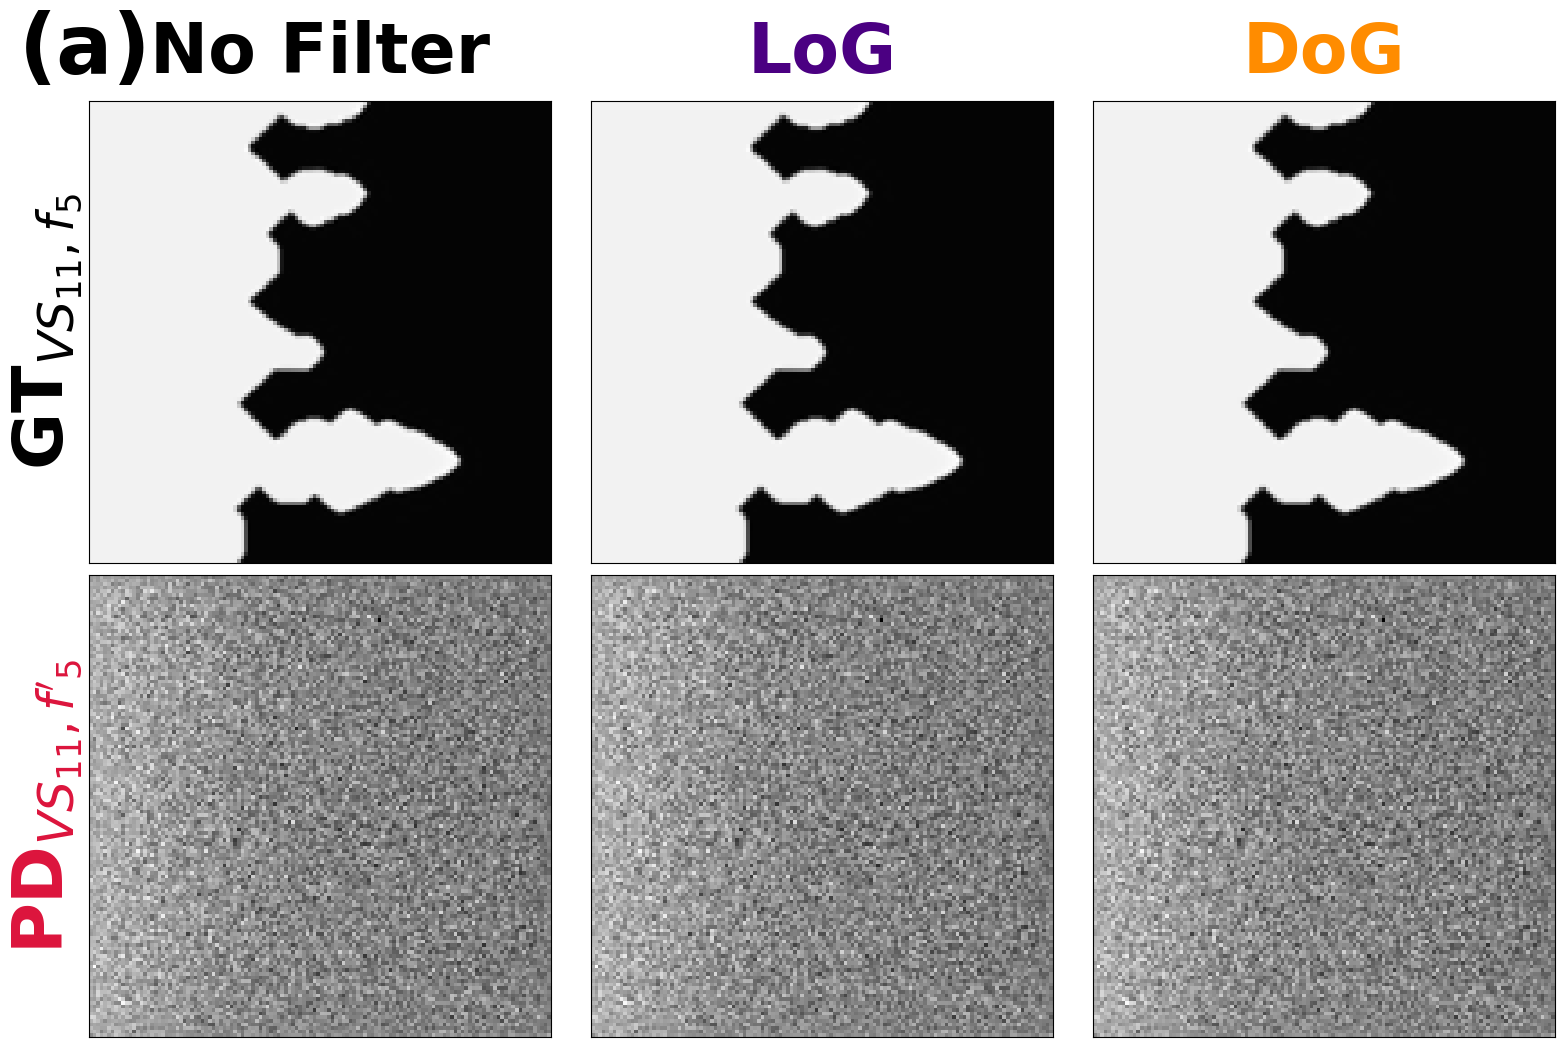

✅ Blob 检测图已保存到: results\blobs_comparison.png


In [20]:
##########################################################
# 📊 可视化：Blob 检测（LoG / DoG）比较 GT 与 预测图
##########################################################
from skimage.feature import blob_dog, blob_log
from math import sqrt

# 从当前 batch 获取单张图像
img_gt = x.detach().cpu().numpy()[0, 0, :, :]
img_pd = recon_x.detach().cpu().numpy()[0, 0, :, :]

vs, f = 11, 5  # 可按需修改
VS_F = r"$_{VS_{%s}, f_{%s}}$"%(vs,f)
VS_F_P = r"$_{VS_{%s}, f'_{%s}}$"%(vs,f)

# ========== Blob 检测 ==========
log_gt = blob_log(img_gt, max_sigma=30, num_sigma=10, threshold=0.1)
log_pd = blob_log(img_pd, max_sigma=30, num_sigma=10, threshold=0.1)
log_gt[:, 2] *= sqrt(2)
log_pd[:, 2] *= sqrt(2)

dog_gt = blob_dog(img_gt, max_sigma=30, threshold=0.1)
dog_pd = blob_dog(img_pd, max_sigma=30, threshold=0.1)
dog_gt[:, 2] *= sqrt(2)
dog_pd[:, 2] *= sqrt(2)

# ========== 绘图 ==========
plt.rcParams["figure.figsize"] = (16, 10.5)
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3)
Algo = ["LoG", "DoG"]

# --- 上排: Ground Truth ---
ax1.imshow(img_gt, cmap="gray")
ax1.set_ylabel('GT' + VS_F, fontsize=50, weight='bold', color='k')
ax1.set_title("No Filter", fontsize=50, weight='bold', pad=20)

ax2.imshow(img_gt, cmap="gray")
ax2.set_title(Algo[0], fontsize=50, weight='bold', color='indigo', pad=20)

ax3.imshow(img_gt, cmap="gray")
ax3.set_title(Algo[1], fontsize=50, weight='bold', color='darkorange', pad=20)

# --- 下排: Predicted ---
ax4.imshow(img_pd, cmap="gray")
ax4.set_ylabel('PD' + VS_F_P, fontsize=50, weight='bold', color='crimson')

ax5.imshow(img_pd, cmap="gray")
ax6.imshow(img_pd, cmap="gray")

# --- 统一刻度与边框 ---
for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
    ax.tick_params(axis='both', labelcolor='black', labelsize=45, bottom=False, top=False,
                   left=False, right=False, labelbottom=False, labelleft=False)

# --- 绘制 GT blobs ---
for blob in log_gt:
    y, x, r = blob
    ax2.add_patch(plt.Circle((x, y), r, color='lime', linewidth=4, fill=False))
for blob in dog_gt:
    y, x, r = blob
    ax3.add_patch(plt.Circle((x, y), r, color='lime', linewidth=4, fill=False))

# --- 绘制 PD blobs ---
for blob in log_pd:
    y, x, r = blob
    ax5.add_patch(plt.Circle((x, y), r, color='orangered', linewidth=4, fill=False))
for blob in dog_pd:
    y, x, r = blob
    ax6.add_patch(plt.Circle((x, y), r, color='orangered', linewidth=4, fill=False))

# --- 标签 ---
ax1.text(-20, -8, "(a)", fontsize=60, weight='bold', color='k')

plt.tight_layout()

save_path = os.path.join("results", "blobs_comparison.png")
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path, transparent=True, dpi=300)
plt.show()

print(f"✅ Blob 检测图已保存到: {save_path}")

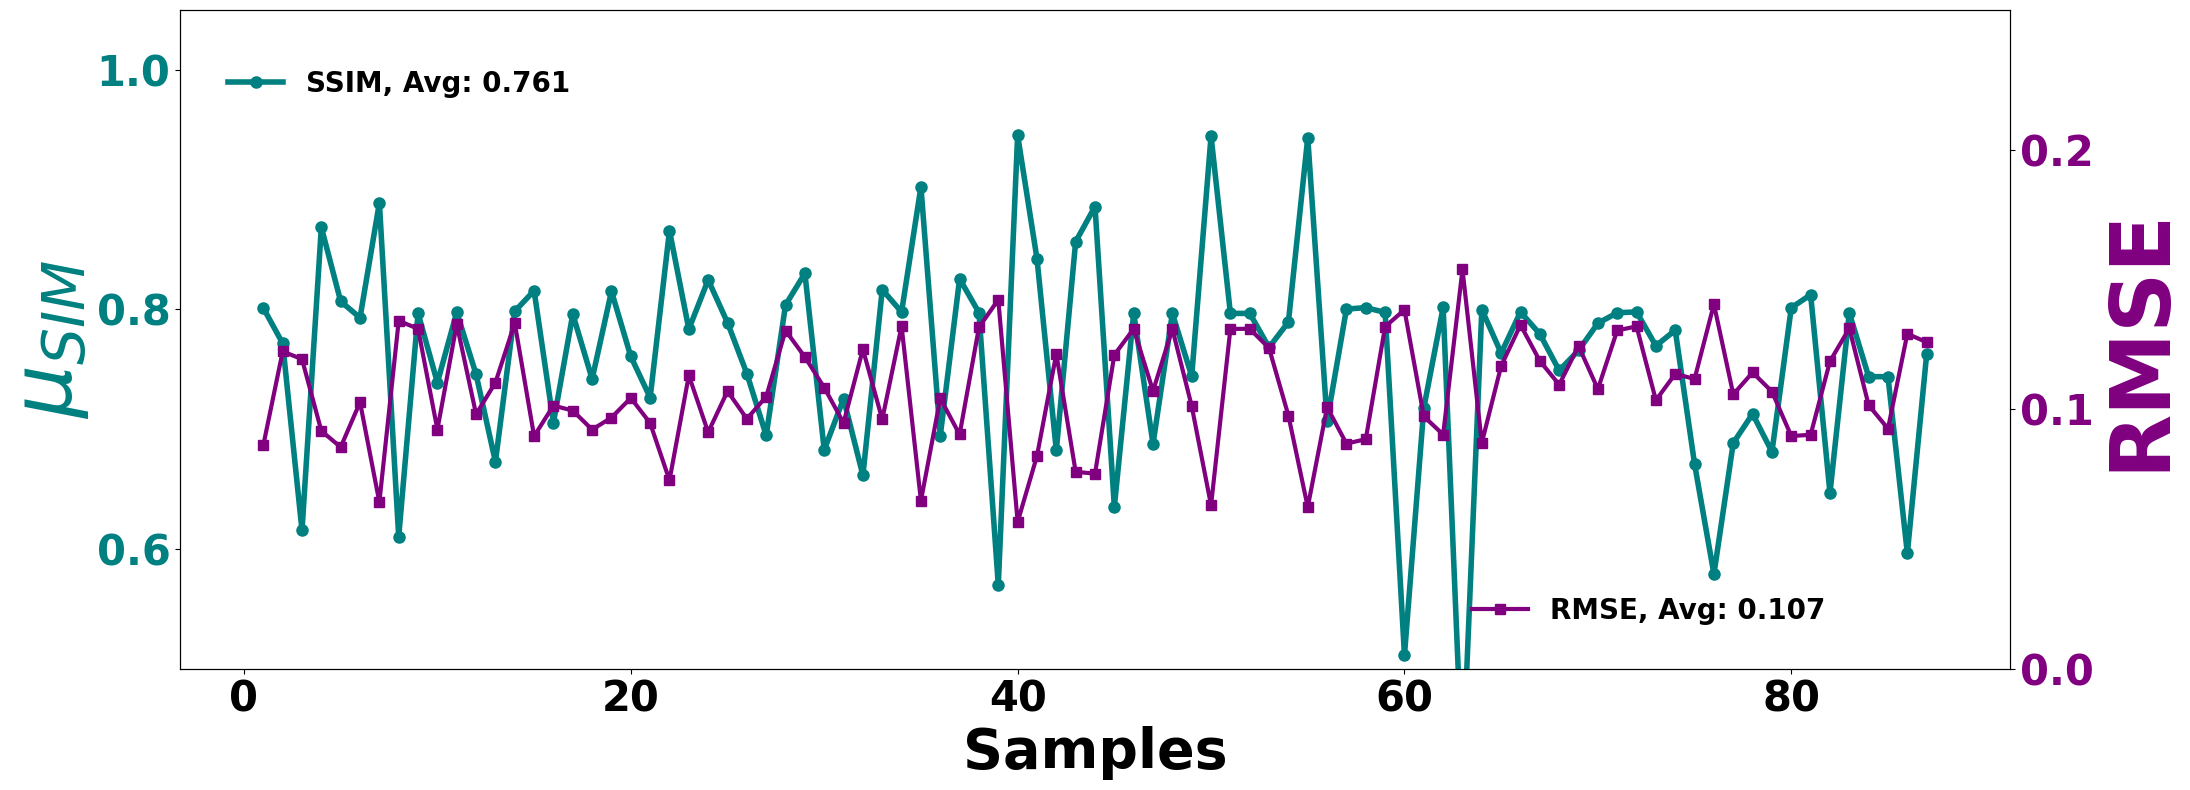

In [14]:
# 可选：平均值
rmse_avg = np.mean(rmses)
ssim_avg = np.mean(ssims)

# 设置全局画布参数
plt.rcParams["figure.figsize"] = (22, 8)

# 创建图和坐标轴
fig, ax1 = plt.subplots()

# 横轴编号
x = np.arange(1, len(rmses) + 1)

# 绘制 SSIM 曲线
ax1.plot(x, ssims, '-o', color='teal', linewidth=4, markersize=8,
         label=f'SSIM, Avg: {ssim_avg:.3f}')
ax1.set_xlabel("Samples", size=40, weight='bold')
ax1.set_ylabel(r"$\mu_{SIM}$", size=60, color='teal', weight='bold')
ax1.tick_params(axis='y', labelcolor='teal', labelsize=30)
ax1.tick_params(axis='x', labelcolor='black', labelsize=30)
ax1.set_ylim([0.5, 1.05])

# 创建右侧轴绘制 RMSE
ax2 = ax1.twinx()
ax2.plot(x, rmses, '-s', color='purple', linewidth=3, markersize=7,
         label=f'RMSE, Avg: {rmse_avg:.3f}')
ax2.set_ylabel("RMSE", size=60, color='purple', weight='bold')
ax2.tick_params(axis='y', labelcolor='purple', labelsize=30)
ax2.set_ylim([0, max(rmses) + 0.1])

# 设置主刻度数量
ax1.xaxis.set_major_locator(plt.MaxNLocator(6))
ax1.yaxis.set_major_locator(plt.MaxNLocator(3))
ax2.yaxis.set_major_locator(plt.MaxNLocator(3))

# 添加图例
ax1.legend(loc=(0.02, 0.85), prop={'weight': 'bold', 'size': 20}, frameon=False)
ax2.legend(loc=(0.7, 0.05), prop={'weight': 'bold', 'size': 20}, frameon=False)

# 加粗坐标轴标签
for label in ax1.get_xticklabels(): label.set_fontweight('bold')
for label in ax1.get_yticklabels(): label.set_fontweight('bold')
for label in ax2.get_yticklabels(): label.set_fontweight('bold')

# 添加标注文字
# plt.text(-0.3, 1.02, "(a)", fontsize=70, weight='bold')

plt.tight_layout()
plt.show()
